In [93]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import torch

In [94]:
class MSHEContrastEnhancement:
    
    def __init__(self, image, num_intervals=2):
        self.image = image
        self.num_intervals = num_intervals

    def linear_stretching(self, img):
        img_min, img_max = img.min(), img.max()
        stretched = ((img - img_min) / (img_max - img_min) * 185 + 35).astype(np.uint8)  #! Adjusted range [35, 220], why? cause it's giving better results (need to check how)
        return stretched

    def divide_histogram(self, img):
        thresholds = [0] + list(np.linspace(0, 255, self.num_intervals + 1)[1:-1]) + [255]
        subhistograms = [(img >= thresholds[i]) & (img <= thresholds[i + 1]) for i in range(len(thresholds) - 1)]
        return subhistograms, thresholds

    def equalize_subhistogram(self, img, mask, min_val, max_val):
        sub_img = img[mask]
        if len(sub_img) > 1:
            hist, bins = np.histogram(sub_img, bins=256, range=(min_val, max_val))
            cdf = hist.cumsum()
            cdf = np.clip(255 * cdf / cdf[-1], 35, 220)  # ! range [35, 220] -> same as above
            img[mask] = np.interp(sub_img, bins[:-1], cdf).astype(np.uint8)
        return img

    def enhance_contrast(self):
        stretched_img = self.linear_stretching(self.image)
        subhistograms, thresholds = self.divide_histogram(stretched_img)
        
        for i, mask in enumerate(subhistograms):
            stretched_img = self.equalize_subhistogram(stretched_img, mask, thresholds[i], thresholds[i + 1])
        
        # ! Applying bilateral filter to smooth the image -> it's giving better results (based on medium article)
        smoothed_img = cv2.bilateralFilter(stretched_img, d=5, sigmaColor=50, sigmaSpace=50)
        return smoothed_img

In [95]:
"""
    Make sure to have the following directory structure:
    turbid-image-enhancement
    ├── data
    |   ├── dataset
    |   |   ├── train
    |   |   |   ├── all the directories containing images
    
    ! Make sure to have this, or else you need to change the code accordingly
"""

class UnderwaterImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [
            os.path.join(subdir, file)
            for subdir, _, files in os.walk(root_dir)
            for file in files if file.endswith(('png', 'jpg', 'jpeg'))
        ]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [96]:
def show_images(original, enhanced):
    """
    Display original and enhanced images side by side.
    """
    fig, axs = plt.subplots(2, len(original), figsize=(12, 6))
    for i in range(len(original)):
        
        if original[i].shape[0] == 3:
            axs[0, i].imshow(np.transpose(original[i], (1, 2, 0)))
        else:
            axs[0, i].imshow(original[i].squeeze(), cmap='gray')
        
        axs[0, i].axis('off')
        axs[0, i].set_title("Original")
        
        if enhanced[i].shape[0] == 3:
            axs[1, i].imshow(np.transpose(enhanced[i], (1, 2, 0)))
        else:
            axs[1, i].imshow(enhanced[i].squeeze(), cmap='gray')
    
        axs[1, i].axis('off')
        axs[1, i].set_title("Enhanced")

    plt.show()

In [97]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])


# Here, we load the dataset
dataset = UnderwaterImageDataset(root_dir='../data/dataset/train', transform=transform) # ! Change the path accordingly, if required
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

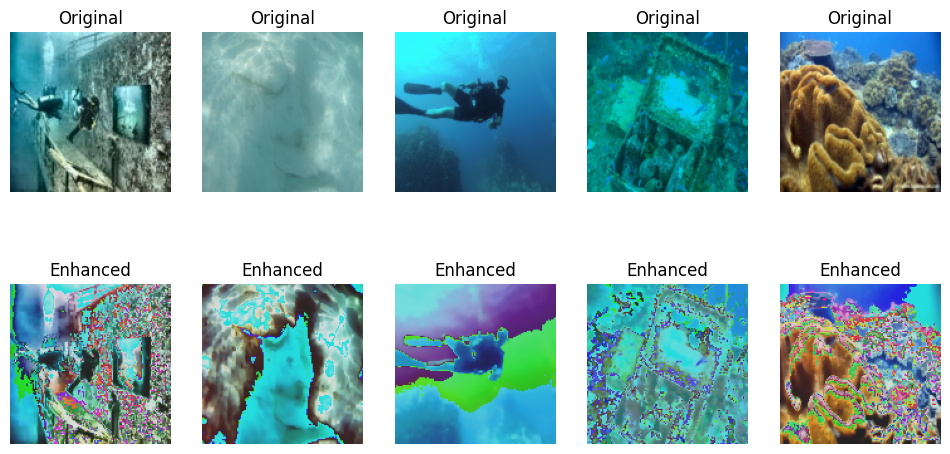

In [110]:
data_iter = iter(dataloader)
images = next(data_iter)

enhanced_images = []
for image in images:
    image_np = (image.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    enhancer = MSHEContrastEnhancement(image_np, num_intervals=2)
    enhanced_image = enhancer.enhance_contrast()
    enhanced_image_tensor = torch.tensor(enhanced_image).permute(2, 0, 1) / 255.0
    enhanced_images.append(enhanced_image_tensor)

# Display images
show_images(images, enhanced_images)